In [20]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


### 7 bands implementation results

For the solving solving of atmospheric parameters, I have implemented the constrain by 7 bands instead of only using one band.

In [85]:
import sys
sys.path.insert(0, 'python')
from fastRWpkl import *
import pylab as plt
%matplotlib inline
import mgrs
from smoothn import smoothn
from scipy.interpolate import griddata
import pandas as pd
from scipy import interpolate
from nicer_plot import *

In [86]:
paras = parallel_rw_pkl(0,'Xingtai0503_atm', 'r')

In [87]:
valid = np.array([np.hstack([i[0], i[1][0], i[1][1]]) for i in paras])

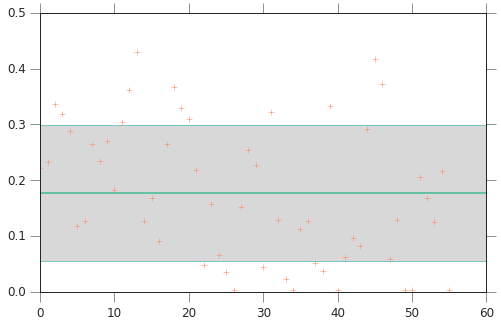

In [162]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(valid[:,2],"+", lw=1)
ax.plot([0,60], [0.055635924179828794, 0.055635924179828794 ], '-',color='#20b2aa', lw=0.5)
ax.plot([0,60], [0.29884952630476158, 0.29884952630476158 ], '-',color='#20b2aa', lw=0.5)
ax.plot([0,60], [0.17724272524229517,0.17724272524229517])
ax.fill_between(np.arange(0,62),0.055635924179828794, 0.29884952630476158, color='grey', alpha=0.3 )
ax.set_ylim(0,0.5)
ax.set_xlim(0,60)
plt.savefig('AOT.pdf')

In [109]:
valid[:,2].mean(), valid[:,2].std()

(0.17724272524229517, 0.12160680106246638)

In [ ]:

def geo_inter(coords, dic, corners):
    '''
    coords is the coordinates [(lat, lon), (lat, lon)...] needed to transfer
    
    dic is a dictionary of the Upper lfet (UL), UR, LL, LR 's lat and lons
    
    example: dic ={'LL_LAT': 36.35288,
                   'LL_LON': 113.00651,
                   'LR_LAT': 36.41186,
                   'LR_LON': 115.6326,
                   'UL_LAT': 38.51077,
                   'UL_LON': 112.88999,
                   'UR_LAT': 38.57451,
                   'UR_LON': 115.59258}
    
    corners is the (x, y) corresponding to the shape of the area (array)            
    '''
    #lat, lon = coords
    a = np.matrix([[1, dic['LL_LAT'], dic['LL_LON'], dic['LL_LAT']*dic['LL_LON']],
                   [1, dic['UL_LAT'], dic['UL_LON'], dic['UL_LAT']*dic['UL_LON']], 
                   [1, dic['LR_LAT'], dic['LR_LON'], dic['LR_LAT']*dic['LR_LON']],
                   [1, dic['UR_LAT'], dic['UR_LON'], dic['UR_LAT']*dic['UR_LON']]])
    x0, y0 = corners
    convs = np.matrix([[1, i[0], i[1], i[0]*i[1]] for i in coords]).T
    x = np.matrix([x0,0,x0,0])*((a**-1).T)*convs
    y = np.matrix([0,0,y0,y0])*((a**-1).T)*convs
    return zip(np.squeeze(np.array(np.round(x).astype('int'))), np.squeeze(np.array((np.round(y).astype('int')))))

In [244]:
[valid[:,2].mean()- valid[:,2].std(), valid[:,2].mean()+ valid[:,2].std()]

[0.055635924179828794, 0.29884952630476158]

In [77]:
(valid[:,0]).astype('int'),(valid[:,1]).astype('int')

(array([7984, 7985, 7987, 7988, 7989, 7991, 7992, 7993, 7995, 8030, 8031,
        8033, 8034, 8035, 8037, 8038, 8039, 8041, 8079, 8080, 8081, 8083,
        8084, 8085, 8087, 8126, 8127, 8129, 8130, 8131, 8132, 8173, 8177,
        8178, 8180, 8222, 8223, 8224, 8226, 8267, 8269, 8270, 8272, 8309,
        8310, 8311, 8314, 8315, 8316, 8318, 8355, 8360, 8361, 8362, 8364,
        8365]),
 array([6380, 6427, 6473, 6520, 6566, 6612, 6659, 6705, 6752, 6369, 6416,
        6462, 6509, 6555, 6602, 6648, 6694, 6741, 6451, 6498, 6544, 6591,
        6637, 6684, 6730, 6487, 6533, 6580, 6626, 6673, 6719, 6523, 6662,
        6708, 6755, 6605, 6651, 6697, 6744, 6547, 6640, 6687, 6733, 6397,
        6444, 6490, 6583, 6629, 6676, 6722, 6386, 6572, 6618, 6665, 6711,
        6758]))

In [110]:
lat,lon=37.181944, 114.36
tx = mgrs.MGRS()
mg = tx.toMGRS(lat,lon, MGRSPrecision=4)
imgx = 9999-int(mg[-4:]); imgy = int(mg[-8:-4])
lx = imgx-200; ux = imgx+200
ly = imgy-200; uy = imgy+200

In [111]:
co_x,co_y = (valid[:,0]).astype('int')-lx, (valid[:,1]).astype('int')-ly
imgx-lx,imgy-ly

(200, 200)

In [112]:
co_x, co_y,valid[:,2]

(array([ 17,  18,  20,  21,  22,  24,  25,  26,  28,  63,  64,  66,  67,
         68,  70,  71,  72,  74, 112, 113, 114, 116, 117, 118, 120, 159,
        160, 162, 163, 164, 165, 206, 210, 211, 213, 255, 256, 257, 259,
        300, 302, 303, 305, 342, 343, 344, 347, 348, 349, 351, 388, 393,
        394, 395, 397, 398]),
 array([ 16,  63, 109, 156, 202, 248, 295, 341, 388,   5,  52,  98, 145,
        191, 238, 284, 330, 377,  87, 134, 180, 227, 273, 320, 366, 123,
        169, 216, 262, 309, 355, 159, 298, 344, 391, 241, 287, 333, 380,
        183, 276, 323, 369,  33,  80, 126, 219, 265, 312, 358,  22, 208,
        254, 301, 347, 394]),
 array([ 0.22268585,  0.23218274,  0.33636125,  0.318912  ,  0.28812599,
         0.11707627,  0.12627061,  0.26474031,  0.23529835,  0.27048205,
         0.18226519,  0.30376627,  0.3609686 ,  0.42915508,  0.1261214 ,
         0.16784543,  0.0913285 ,  0.26504719,  0.3673474 ,  0.3292817 ,
         0.30920638,  0.21749633,  0.0475546 ,  0.15767451,  0.0

In [113]:
aot = np.zeros((400,400))
aot[:]=np.nan

In [114]:
aot[co_x, co_y]=valid[:,2]

In [115]:
w = (~np.isnan(aot))*1.
w[co_x, co_y] = valid[:,-1]
aot[np.isnan(aot)] = valid[:,2].mean()

In [116]:
aot_map = smoothn(aot, W=w, isrobust=1, s=100, MaxIter=1000)
aot_map

python/smoothn.py:193: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if W != None:
python/smoothn.py:211: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if W == None:


(array([[ 0.17760354,  0.17760332,  0.17760288, ...,  0.17743755,
          0.17743771,  0.17743778],
        [ 0.17760351,  0.17760329,  0.17760285, ...,  0.17743757,
          0.17743772,  0.1774378 ],
        [ 0.17760346,  0.17760324,  0.1776028 , ...,  0.1774376 ,
          0.17743776,  0.17743783],
        ..., 
        [ 0.17582804,  0.17582897,  0.17583084, ...,  0.17516509,
          0.17516136,  0.17515947],
        [ 0.17582589,  0.17582683,  0.1758287 , ...,  0.17516416,
          0.17516037,  0.17515846],
        [ 0.17582482,  0.17582575,  0.17582762, ...,  0.17516373,
          0.17515991,  0.17515798]]),
 100.0,
 True,
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

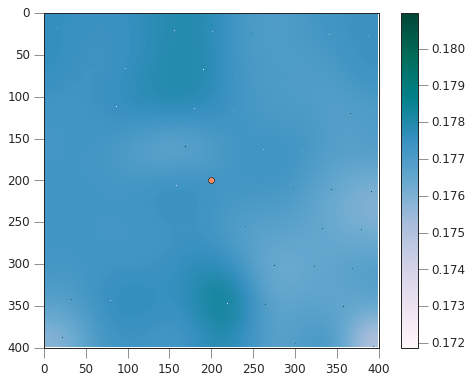

In [214]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(aot_map[0], interpolation='None', cmap=plt.cm.get_cmap('PuBuGn'))
ax.plot(200,200, 'o')
ax.set_xlim(0,400)
ax.set_ylim(400,0)
fig.colorbar(im, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('aeromap.pdf')

In [140]:
aot_map[0][200,200]

0.17722309347437556

In [141]:
aot_map[0][200,200]

0.17722309347437556

In [173]:
grid_x, grid_y = np.mgrid[0:400, 0:400]
aots = griddata(np.array([co_x, co_y]).T, valid[:,2], (grid_x, grid_y),method='nearest')

In [164]:
pas = ['Date(dd-mm-yyyy)', 'Time(hh:mm:ss)', 'Julian_Day', 'AOT_1640', 
       'AOT_1020', 'AOT_870', 'AOT_675', 'AOT_667', 'AOT_555', 'AOT_551', 'AOT_532', 
       'AOT_531', 'AOT_500', 'AOT_490', 'AOT_443', 'AOT_440', 'AOT_412', 'AOT_380', 'AOT_340', 'Water(cm)']
df = pd.read_csv('160101_161231_SONET_Xingtai.dubovik', skiprows=3, na_values=["N/A"])
date = df[pas][4:12]
aero = np.array(date.AOT_1640),np.array(date.AOT_1020),np.array(date.AOT_870),np.array(date.AOT_675),np.array(date.AOT_500),np.array(date.AOT_440),np.array(date.AOT_380),np.array(date.AOT_340)
wv = [1640, 1020,870, 675, 500, 440, 380, 340]
aero = np.array(aero).T
date

,Date(dd-mm-yyyy),Time(hh:mm:ss),Julian_Day,AOT_1640,AOT_1020,AOT_870,AOT_675,AOT_667,AOT_555,AOT_551,AOT_532,AOT_531,AOT_500,AOT_490,AOT_443,AOT_440,AOT_412,AOT_380,AOT_340,Water(cm)
4,03:05:2016,00:07:15,124.005035,0.031110,0.042359,0.047588,0.060134,NaN,NaN,NaN,NaN,NaN,0.066739,NaN,NaN,0.076337,NaN,0.084082,0.091142,0.511909
5,03:05:2016,00:37:15,124.025868,0.029541,0.039815,0.045460,0.058063,NaN,NaN,NaN,NaN,NaN,0.062091,NaN,NaN,0.071493,NaN,0.078761,0.077383,0.486975
6,03:05:2016,01:22:19,124.057164,0.031955,0.041477,0.047839,0.060413,NaN,NaN,NaN,NaN,NaN,0.060192,NaN,NaN,0.069243,NaN,0.075497,0.070629,0.447453
7,03:05:2016,07:22:17,124.307141,0.081640,0.090919,0.101287,0.118541,NaN,NaN,NaN,NaN,NaN,0.135848,NaN,NaN,0.152733,NaN,0.174680,0.192274,0.760989
8,03:05:2016,08:37:27,124.359340,0.091557,0.102394,0.111964,0.129180,NaN,NaN,NaN,NaN,NaN,0.155331,NaN,NaN,0.176462,NaN,0.202620,0.220729,0.824685
9,03:05:2016,09:32:01,124.397234,0.097034,0.110542,0.120147,0.141056,NaN,NaN,NaN,NaN,NaN,0.180543,NaN,NaN,0.208450,NaN,0.244123,0.268813,0.877700
10,03:05:2016,10:06:10,124.420949,0.102942,0.117834,0.126913,0.147866,NaN,NaN,NaN,NaN,NaN,0.190915,NaN,NaN,0.219997,NaN,0.256489,0.279838,0.903077
11,03:05:2016,22:46:36,124.949028,0.110888,0.134589,0.139996,0.154928,NaN,NaN,NaN,NaN,NaN,0.181862,NaN,NaN,0.201206,NaN,0.222006,0.231482,1.120504


In [193]:
hours = [datetime.datetime.strptime(i, '%H:%M:%S').hour+datetime.datetime.strptime(i, '%H:%M:%S').minute/60.+datetime.datetime.strptime(i, '%H:%M:%S').second/3600. for i in list(date['Time(hh:mm:ss)'])]

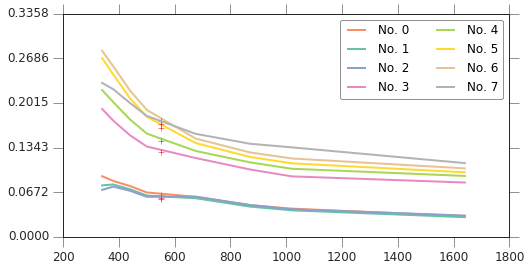

In [170]:
aot550 = []
#plot_config()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for i,j in enumerate(aero):
    ax.plot(wv, j, label = 'No. %s'%i)
    f = interpolate.interp1d(wv,j, kind='cubic')
    xnew = 550
    ynew = f(xnew)
    aot550.append(ynew)
    plt.plot(550, ynew, 'r+')
#pretty_axes(ax)  
ax.set_yticks(np.linspace(0, 1.2*np.max(aero), 6))
plt.legend(ncol=2)

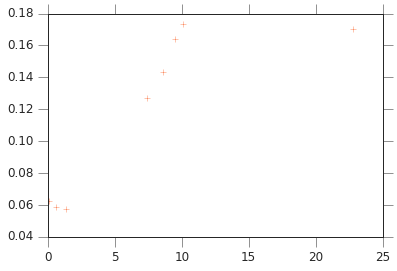

In [198]:
plt.plot(hours,aot550, "+")

In [207]:
np.array([hours, aot550]).shape

(2, 8)

In [212]:
import scipy
re = scipy.stats.linregress(np.array([hours, aot550])[:,2:7][0],np.array([hours, aot550])[:,2:7][1])
re.slope*11.+re.intercept

0.17990054107136419

In [41]:
w = np.arange(500, 2200).astype('float')
W = (np.array(w)/w[0])**(-1.4)

In [42]:
plot_config()

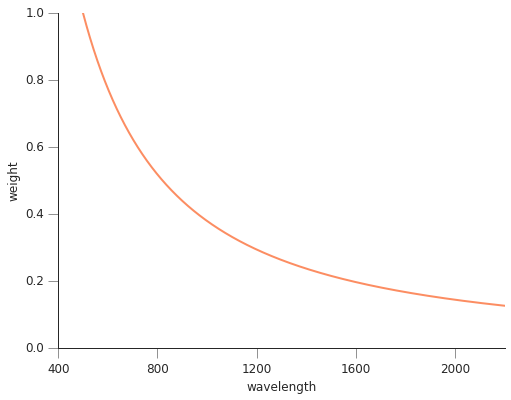

In [83]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(w,W)
ax.set_ylabel('weight')
ax.set_xlabel('wavelength')
pretty_axes(ax)
ax.set_yticks(np.arange(0,1.1,0.2))
ax.set_yticklabels(np.arange(0,1.1,0.2))
plt.savefig('weight.pdf')

In [79]:
ax.plot?

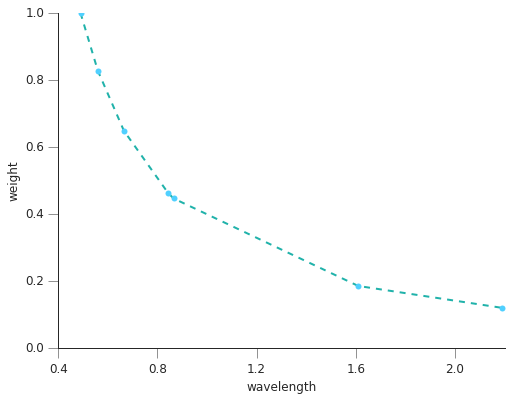

In [84]:
wl=0.490,0.560,0.665,0.842,0.865,1.610,2.190
ws = (np.array(wl)/wl[0])**(-1.42)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(wl,ws,'--o',color = '#20b2aa', mfc='#50d0ff', markeredgewidth=0)
ax.set_ylabel('weight')
ax.set_xlabel('wavelength')
pretty_axes(ax)
ax.set_yticks(np.arange(0,1.1,0.2))
ax.set_yticklabels(np.arange(0,1.1,0.2))
plt.savefig('bandweight.pdf')

In [55]:
np.arange(0,1.1,0.2)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [50]:
ax.set_yticklabels?

In [53]:
ax.set_yticks?